In [12]:
!pip install tqdm scipy numpy jax h5py

Code adapted from: https://github.com/zzhangzzhang/pLMs-interpretability/tree/main

In [1]:
import time
import os 
import torch 
import json 
from tqdm import tqdm 
import numpy as np
from scipy.special import softmax
from utils import *
import random 
import matplotlib.pyplot as plt

In [6]:
pid = "3LAEA"
sequence = "SNAIQQSDGSMIIDGSANLRDLNKMFNWELDTEDARTFNGLILEHLEEIPDEGTICEIDGLLITILEVGDNMIKQAKVVKL"
print(len(sequence))

81


In [2]:
# LOAD MODEL AND PUT TO GPU / Validation: higher similiarity ok: 50%
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t6_8M_UR50D")
# put model on GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
model = model.to(device)
model = model.eval()
#model.args.token_dropout = False

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /Users/cw_liao/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /Users/cw_liao/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /Users/cw_liao/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [3]:
# LOAD BIGGER MODEL
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t12_35M_UR50D")
# put model on GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
model = model.to(device)
model = model.eval()
#model.args.token_dropout = False

Using cache found in /Users/cw_liao/.cache/torch/hub/facebookresearch_esm_main
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t12_35M_UR50D.pt" to /Users/cw_liao/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t12_35M_UR50D-contact-regression.pt" to /Users/cw_liao/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D-contact-regression.pt


In [1]:
def get_categorical_jacobian(seq):
  # ∂in/∂out
  x,ln = alphabet.get_batch_converter()([("seq",seq)])[-1],len(seq)
  with torch.no_grad():
    f = lambda x: model(x)["logits"][...,1:(ln+1),4:24].cpu().numpy()
    fx = f(x.to(device))[0]
    x = torch.tile(x,[20,1]).to(device)
    fx_h = np.zeros((ln,20,ln,20))
    for n in range(ln): # for each position
      x_h = torch.clone(x)
      x_h[:,n+1] = torch.arange(4,24) # mutate to all 20 aa
      fx_h[n] = f(x_h)
    return fx_h - fx
def get_contacts(x, symm=True, center=True, rm=1, normalize="sigmoid"):
  # convert jacobian (L,A,L,A) to contact map (L,L)
  j = x.copy()
  if center:
    for i in range(4): j -= j.mean(i,keepdims=True)
  j_fn = np.sqrt(np.square(j).sum((1,3)))
  np.fill_diagonal(j_fn,0)
  j_fn_corrected = do_apc(j_fn, rm=rm)
  if symm:
    j_fn_corrected = (j_fn_corrected + j_fn_corrected.T)/2
    # Normalize
    if normalize == "sigmoid":
        # Apply sigmoid with optional scaling
        j_fn_corrected = sigmoid_normalize(j_fn_corrected)
    elif normalize == "minmax":
        # Min-max normalization to [0,1]
        j_fn_corrected = minmax_normalize(j_fn_corrected)
        
    return j_fn_corrected


def do_apc(x, rm=1):
  '''given matrix do apc correction'''
  # trying to remove different number of components
  # rm=0 remove none
  # rm=1 apc
  x = np.copy(x)
  if rm == 0:
    return x
  elif rm == 1:
    a1 = x.sum(0,keepdims=True)
    a2 = x.sum(1,keepdims=True)
    y = x - (a1*a2)/x.sum()
  else:
    # decompose matrix, rm largest(s) eigenvectors
    u,s,v = np.linalg.svd(x)
    y = s[rm:] * u[:,rm:] @ v[rm:,:]
  np.fill_diagonal(y,0)
  return y


def sigmoid_normalize(x, temperature=1.0):
    """
    Normalize values using sigmoid function with temperature scaling
    
    Args:
        x: Input array
        temperature: Controls steepness of sigmoid (lower = steeper)
    """
    # Center the values to help with sigmoid
    x = x - x.mean()
    # Scale values to help with sigmoid range
    x = x / x.std()
    # Apply sigmoid with temperature
    return 1 / (1 + np.exp(-x/temperature))

def minmax_normalize(x):
    """Min-max normalization to [0,1] range"""
    x_min, x_max = x.min(), x.max()
    if x_max > x_min:
        return (x - x_min) / (x_max - x_min)
    return x

In [2]:
import numpy as np
import torch

def contact_map_to_distances(contact_map, n_bins=36, min_dist=2.0, max_dist=22.0):
    """
    Convert a contact map to binned distances
    
    Parameters:
    -----------
    contact_map : np.ndarray
        2D numpy array of contact probabilities (L x L)
    n_bins : int
        Number of distance bins to use
    min_dist : float
        Minimum distance in Angstroms
    max_dist : float
        Maximum distance in Angstroms
        
    Returns:
    --------
    distances : np.ndarray
        LxL matrix of predicted distances (mean of most likely bin)
    distance_probs : np.ndarray
        LxLxB tensor of probabilities for each distance bin
    bin_edges : np.ndarray
        Array of bin boundaries
    """
    # Create distance bins
    bin_edges = np.linspace(min_dist, max_dist, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Convert contact probabilities to distance probabilities
    L = contact_map.shape[0]
    distance_probs = np.zeros((L, L, n_bins))
    
    # For each position pair
    for i in range(L):
        for j in range(L):
            if i != j:
                contact_prob = contact_map[i,j]
                
                # If high contact probability, concentrate around typical Cβ-Cβ distance (8Å)
                if contact_prob > 0.5:
                    mu = 8.0  # typical Cβ-Cβ distance for contacts
                    sigma = 2.0 * (1 - contact_prob)  # uncertainty scales with 1-prob
                else:
                    mu = 15.0  # typical non-contact distance
                    sigma = 4.0
                
                # Create gaussian distribution over bins
                bin_probs = np.exp(-0.5 * ((bin_centers - mu)/sigma)**2)
                bin_probs = bin_probs / bin_probs.sum()  # normalize
                
                distance_probs[i,j] = bin_probs
    
    # Get mean distance prediction (weighted average of bin centers)
    distances = np.sum(bin_centers[None,None,:] * distance_probs, axis=2)
    
    # Make symmetric
    distances = (distances + distances.T) / 2
    distance_probs = (distance_probs + np.transpose(distance_probs, (1,0,2))) / 2
    
    return distances, distance_probs, bin_edges

def predict_distances(sequence, model, device, alphabet):
    """
    End-to-end prediction of distances from sequence
    
    Parameters:
    -----------
    sequence : str
        Protein sequence
    model : torch.nn.Module
        ESM-2 model
    device : torch.device
        Device to run model on
    alphabet : esm.data.Alphabet
        ESM alphabet object
    
    Returns:
    --------
    distances : np.ndarray
        LxL matrix of predicted distances
    distance_probs : np.ndarray 
        LxLxB tensor of probabilities for each distance bin
    bin_edges : np.ndarray
        Array of bin boundaries
    """
    # Get contact map
    jacobian = get_categorical_jacobian(sequence)
    contacts = get_contacts(jacobian)
    
    # Convert to distances
    return contact_map_to_distances(contacts)

# Example usage
"""
distances, distance_probs, bin_edges = predict_distances(
    sequence="PROTEIN", 
    model=model,
    device=device, 
    alphabet=alphabet
)
"""

'\ndistances, distance_probs, bin_edges = predict_distances(\n    sequence="PROTEIN", \n    model=model,\n    device=device, \n    alphabet=alphabet\n)\n'

In [40]:
seq = "ACDEFGHIKLMNPQRSTVWY"  # Example sequence
jacobian = get_categorical_jacobian(seq)
contact_map = get_contacts(jacobian)
# After getting your contact map
# After getting your contact map
distances, distance_probs, bin_edges = contact_map_to_distances(contact_map)

# You can visualize the results
import matplotlib.pyplot as plt
import seaborn as sns



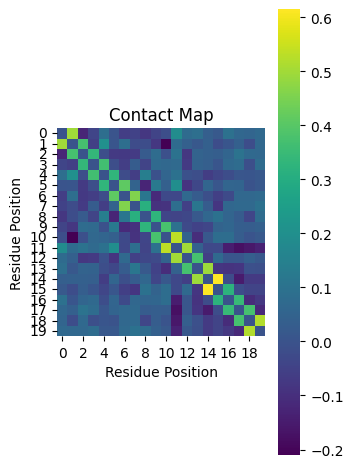

In [41]:


# Plot contact map for comparison
plt.subplot(122)
sns.heatmap(contact_map, cmap='viridis', square=True)
plt.title('Contact Map')
plt.xlabel('Residue Position')
plt.ylabel('Residue Position')
plt.tight_layout()
plt.show()

Text(95.72222222222221, 0.5, 'Residue Position')

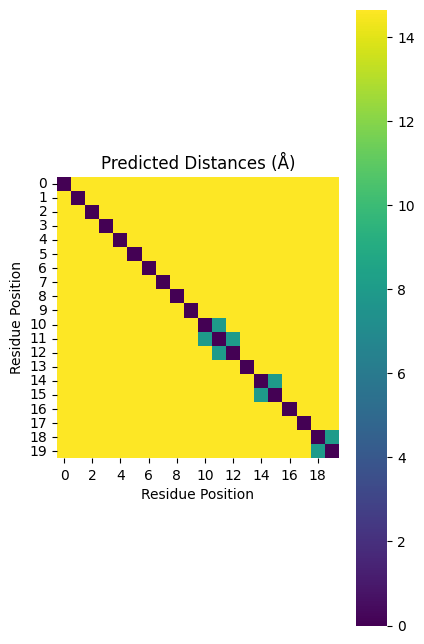

In [42]:
# Plot distance map
plt.figure(figsize=(10, 8))
plt.subplot(121)
sns.heatmap(distances, cmap='viridis', square=True)
plt.title('Predicted Distances (Å)')
plt.xlabel('Residue Position')
plt.ylabel('Residue Position')


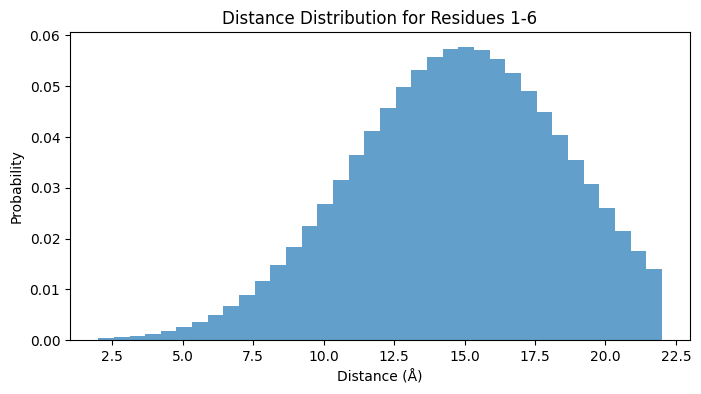

Mean predicted distance: 13.78 Å
Min predicted distance: 0.00 Å
Max predicted distance: 14.65 Å
Predicted distance between residues 1 and 6: 14.65 Å


In [43]:

# To examine specific distance distributions
i, j = 0, 5  # Example residue pair
plt.figure(figsize=(8, 4))
plt.bar(bin_edges[:-1], distance_probs[i,j], 
        width=np.diff(bin_edges), 
        align='edge',
        alpha=0.7)
plt.xlabel('Distance (Å)')
plt.ylabel('Probability')
plt.title(f'Distance Distribution for Residues {i+1}-{j+1}')
plt.show()

# Print some statistics
print(f"Mean predicted distance: {distances.mean():.2f} Å")
print(f"Min predicted distance: {distances.min():.2f} Å")
print(f"Max predicted distance: {distances.max():.2f} Å")

# To get specific residue pair distances
i, j = 0, 5  # Example residue pair
print(f"Predicted distance between residues {i+1} and {j+1}: {distances[i,j]:.2f} Å")

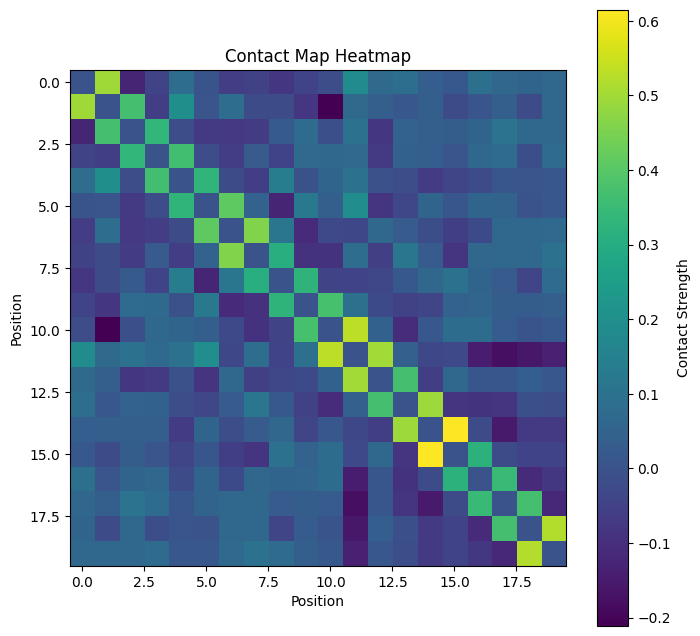

In [34]:
# Plot contact map
# Make the heatmap plot
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Contact Strength")
plt.title("Contact Map Heatmap")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

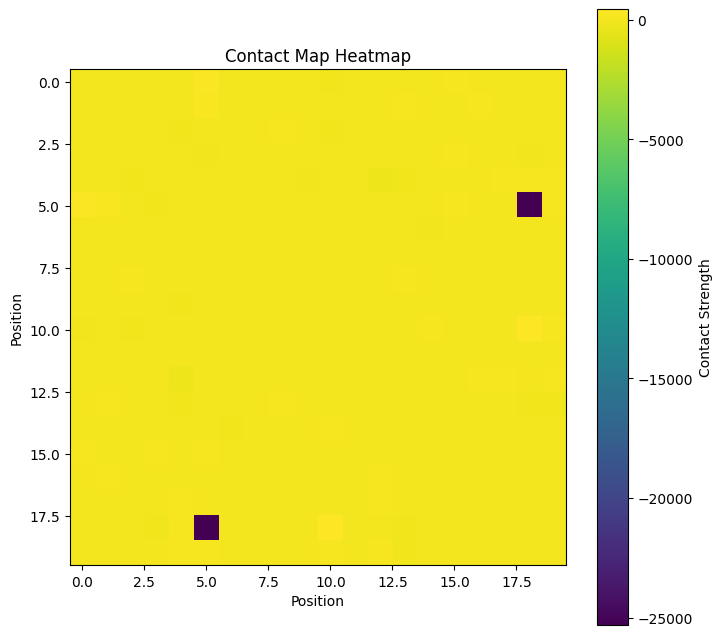

In [35]:
# Plot contact map
# Make the heatmap plot
plt.figure(figsize=(8, 8))
plt.imshow(distance_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Contact Strength")
plt.title("Contact Map Heatmap")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

In [29]:
contact_map.shape

(20, 20)

In [23]:
# calculate Categorical Jacobian Matrix for example sequence
cjm1 = get_categorical_jacobian(sequence)
print(cjm1.shape)

(81, 20, 81, 20)


In [24]:
# Calculate Contact Map from CJM
contact_map = get_contacts(cjm1)
print(contact_map.shape)

(81, 81)


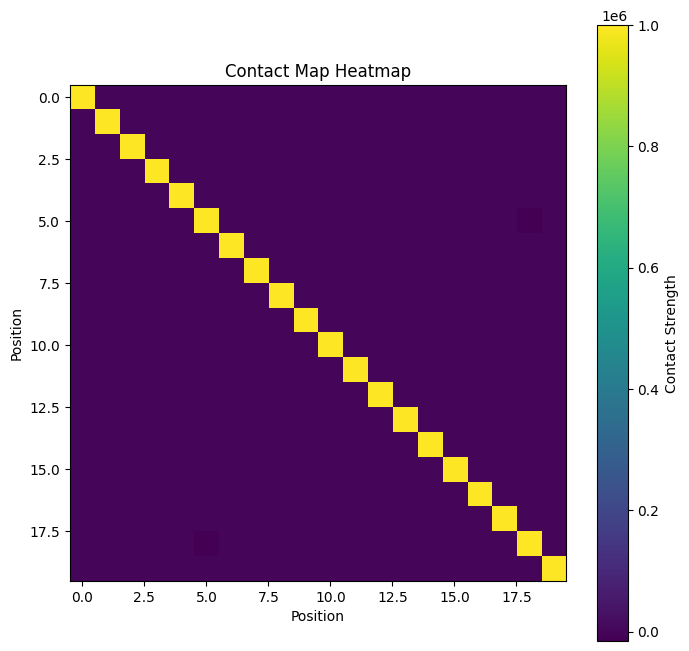

In [25]:
# Plot contact map
# Make the heatmap plot
plt.figure(figsize=(8, 8))
plt.imshow(distance_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Contact Strength")
plt.title("Contact Map Heatmap")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

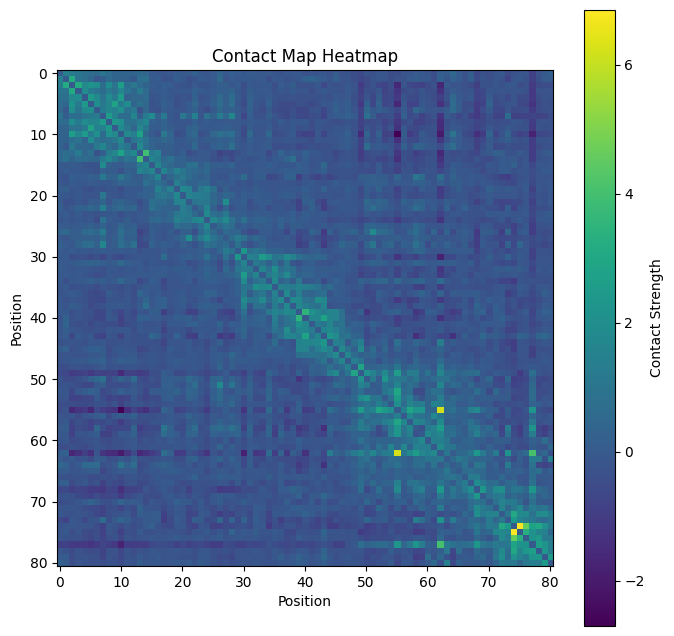

In [26]:
# Plot contact map
# Make the heatmap plot
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Contact Strength")
plt.title("Contact Map Heatmap")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

In [10]:
apc_contact_map = do_apc(contact_map, rm=1)

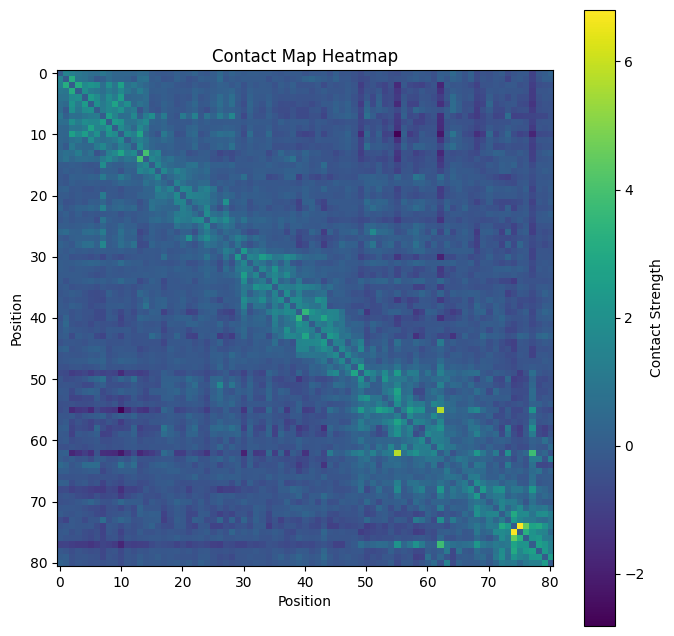

In [11]:
# Plot contact map
# Make the heatmap plot
plt.figure(figsize=(8, 8))
plt.imshow(apc_contact_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Contact Strength")
plt.title("Contact Map Heatmap")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

### Calculate seconds/1000 tokens for calculating it

In [13]:
# Load JSON data from a file into a dictionary
with open('/notebooks/pLMs-interpretability/data/full_seq_dict.json', 'r') as file:
    all_seqs = json.load(file)
print("First 5 keys:", list(all_seqs.keys())[:5])
print("First 5 sequences:", list(all_seqs.values())[:5])
print("Total dict_length:", len(all_seqs.keys()))

First 5 keys: ['2GWGA', '3LAEA', '4MC3A', '1TX4A', '3NHEA']
First 5 sequences: ['MIIDIHGHYTTAPKALEDWRNRQIAGIKDPSVMPKVSELKISDDELQASIIENQLKKMQERGSDLTVFSPRASFMAHHIGDFNVSSTWAAICNELCYRVSQLFPDNFIGAAMLPQSPGVDPKTCIPELEKCVKEYGFVAINLNPDPSGGHWTSPPLTDRIWYPIYEKMVELEIPAMIHVSTSCNTCFHTTGAHYLNADTTAFMQCVAGDLFKDFPELKFVIPHGGGAVPYHWGRFRGLAQEMKKPLLEDHVLNNIFFDTCVYHQPGIDLLNTVIPVDNVLFASEMIGAVRGIDPRTGFYYDDTKRYIEASTILTPEEKQQIYEGNARRVYPRLDAALKAKGKLEHHHHHH', 'SNAIQQSDGSMIIDGSANLRDLNKMFNWELDTEDARTFNGLILEHLEEIPDEGTICEIDGLLITILEVGDNMIKQAKVVKL', 'MAEFEIPDFYVPFPLECNPHLEEASRAMWEWIDANGLAPTERARDRMRRTGADLSGAYVWPRADLDTLTIGLKWIALTFRIDDQIDEDDTAERLPARMTAIDELRGTLHGLPVSGRSPTARALGALWQETALGRPATWCDAFIGHFEAFLQTYTTEAGLNAHGAGLRLDDYLDRRMYSVGMPWLWDLDELRLPIFLPGSVRTCGPMNKLRRAGALHIALVNDVFSVERETLVGYQHNAVTIIREAQGCSLQEAVDQVAVLVEAQLHTVLQARQELLEELDRQALPSRAREAAVDYAANVAANLSGQLVWHSSVERYAVDDLQSAADPRATPTTSSLGILEHHHHHH', 'RPPLPNQQFGVSLQHLQEKNPEQEPIPIVLRETVAYLQAHALTTEGIFRRSANTQVVREVQQKYNMGLPVDFDQYNALHLPAVILKTFLRELPEPLLTFDLYPHVVGFLNIDESQRVPATLQVLQTLPEE

In [8]:
# JACOBIAN MATRIX
import time
from tqdm import tqdm
all_cjm = {}
total_length_of_all_seqs = 0
number_seqs_to_process = 100

# Record the start time
start_time = time.time()

i = 0
for pid, sequence in tqdm(all_seqs.items()):
    total_length_of_all_seqs += len(sequence)
    all_cjm[pid] = get_categorical_jacobian(sequence)
    i += 1
    if i > number_seqs_to_process:
        print("stopping at {i}-th sequence")
        break
        
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time_cjm = end_time - start_time
print("JACOBIAN MATRIX TIME")
print(f"Time elapsed: {elapsed_time_cjm} seconds for {total_length_of_all_seqs} Aminoacids, {i} sequences")
print(f"seconds / 1000 aminoacid = {elapsed_time_cjm} / {total_length_of_all_seqs} * 1000 = {elapsed_time_cjm/total_length_of_all_seqs*1000}")

  5%|▍         | 100/2170 [17:39<6:05:31, 10.60s/it]

stopping at {i}-th sequence
JACOBIAN MATRIX TIME
Time elapsed: 1059.5186512470245 seconds for 29502 Aminoacids, 101 sequences
seconds / 1000 aminoacid = 1059.5186512470245 / 29502 * 1000 = 35.913451672667094


In [9]:
# Single ESM forward pass
# Record the start time
start_time = time.time()

i = 0
for pid, sequence in tqdm(all_seqs.items()):
    x,ln = alphabet.get_batch_converter()([("seq",sequence)])[-1],len(sequence)
    with torch.no_grad():
        f = lambda x: model(x)["logits"][...,1:(ln+1),4:24].cpu().numpy()
        fx = f(x.to(device))[0]
    i += 1
    if i > number_seqs_to_process:
        print("stopping at {i}-th sequence")
        break
        
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time_simple_fw = end_time - start_time
print(f"Time elapsed: {elapsed_time_simple_fw} seconds for {total_length_of_all_seqs} Aminoacids, {i} sequences")
print(f"seconds / 1000 aminoacid = {elapsed_time_simple_fw} / {total_length_of_all_seqs} * 1000 = {elapsed_time_simple_fw/total_length_of_all_seqs*1000}")

  5%|▍         | 100/2170 [00:00<00:14, 144.13it/s]

stopping at {i}-th sequence
Time elapsed: 0.6967625617980957 seconds for 29502 Aminoacids, 101 sequences
seconds / 1000 aminoacid = 0.6967625617980957 / 29502 * 1000 = 0.023617468707141744


In [ ]:
print("Jacobian Matrix:", elapsed_time_cjm)
print("Single pLM forward pass:", elapsed_time_simple_fw)

### Save contact maps as h5py

In [ ]:
from itertools import islice
from tqdm import tqdm
import h5py

# Loop through only the first 200 items
with h5py.File('first_200.h5', 'a') as f:
    for pid, sequence in tqdm(islice(all_seqs.items(), 200)):
        with torch.no_grad():
            cj = get_categorical_jacobian(sequence)
            contact_map = get_contacts(cj)
            f.create_dataset(pid, data=contact_map)


195it [29:23,  6.91s/it]

In [16]:
# Load tensors from HDF5 file
loaded_tensors = {}

with h5py.File('first_200_contact_maps.h5', 'r') as f:
    for key in f.keys():
        # Load each tensor and convert back to torch.Tensor
        loaded_tensors[key] = torch.tensor(f[key][...])

loaded_tensors.keys()

dict_keys(['1ELUA', '1FCYA', '1GDEA', '1IO7A', '1J34B', '1JYKA', '1L7AA', '1LQVA', '1M70A', '1MXRA', '1NNHA', '1NS5A', '1O6VA', '1O97C', '1PZ7A', '1Q0RA', '1Q74A', '1QSAA', '1TX4A', '1USMA', '1V2XA', '1V9FA', '1VAJA', '1VI0A', '1VMHA', '1VYBA', '1WP5A', '1X8BA', '1Y6ZA', '1Y9QA', '1YARH', '2A9DA', '2A9SA', '2B06A', '2B69A', '2BM5A', '2C2IA', '2C6UA', '2C78A', '2CFMA', '2DKJA', '2EK8A', '2FBLA', '2FIUA', '2FNUA', '2GEYA', '2GWGA', '2GYQA', '2H88A', '2HXIA', '2HZQA', '2IWRA', '2JCBA', '2JDIH', '2NP5A', '2NYUA', '2PFZA', '2PLIA', '2Q0DA', '2Q24A', '2Q4ZA', '2QIPA', '2QNIA', '2QTQA', '2R6JA', '2R6VA', '2RASA', '2RK9A', '2W43A', '2WZBA', '2XD3A', '2XE4A', '2YIMA', '2YXBA', '3A1FA', '3A99A', '3AABA', '3AKBA', '3AKEA', '3BE6A', '3BPTA', '3C9UA', '3CCDA', '3CKMA', '3CNGA', '3CNUA', '3CRVA', '3CWVA', '3D1PA', '3D40A', '3DHNA', '3DO6A', '3DUWA', '3E9KA', '3EFBA', '3EJKA', '3ERSX', '3F6GA', '3F6OA', '3FDJA', '3FFRA', '3FP3A', '3G13A', '3G8ZA', '3GIWA', '3GMSA', '3GUYA', '3H7AA', '3HNYM', '3HSYA',